In [1]:
datasetName = 'eye_AdultOmentum2_Guo2020'
#datasetName value: organ_tissue_authorYear without space
dataFormat = 'tsv'
#dataFormat value: tsv (tab separated), 10X (sparse)
setwd("/stor/public/hcad/eye_AdultOmentum2_Guo2020")

In [2]:
library(Seurat)
library(data.table)
library(ggplot2)
# Load the organized dataset
if(dataFormat == 'tsv'){
    data.matrix <- data.table::fread(paste0(datasetName,"_expression.tsv.gz"), h = T, data.table = F)
} else{
   system(paste0("tar -zxvf ", datasetName, "_expression.tar.gz")) #Invoke the unix command
   data.matrix <- Read10X(data.dir = paste0(datasetName,"_expression"))
   # data.dir: Directory containing the matrix.mtx, genes.tsv (or features.tsv), and barcodes.tsv files provided by 10X.
}
# Load the metadata and annotation
data.metadata <- read.table(file = paste0(datasetName,"_metadata.tsv"), h = T, sep = "\t", row.names = 5)
data.annotation <- read.table(file = paste0(datasetName,"_annotation.tsv"), h = T, sep = "\t", row.names = 1)
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    data.annotation2 <- read.table(file = paste0(datasetName,"_annotation2.tsv"), h = T, sep = "\t", row.names = 1)
}


In [3]:
row.names(data.matrix) <- data.matrix[, 1]
data.matrix <- data.matrix[, -1]
data.matrix[1:5, 1:5]
data.metadata[1:5, ]
data.annotation[1:5,]

,AdultOmentum_2.TGCAATAGTTTACCATCT,AdultOmentum_2.CTCGCAGGGCGAAGGACT,AdultOmentum_2.AGCGAGAAAGTTAGTCGT,AdultOmentum_2.TGCAATGAACGCTTCCGC,AdultOmentum_2.AACCTAATCTCTCTTCTG
,<int>,<int>,<int>,<int>,<int>
A1BG-AS1,0,0,0,0,0
A2M,0,0,0,0,0
A2M-AS1,0,0,0,0,0
A2ML1,0,0,0,0,0
A2MP1,0,0,0,0,0


,organ,region,subregion,sample_status,donor_ID,donor_gender,donor_age
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
AdultOmentum_2.TGCAATAGTTTACCATCT,eye,AdultOmentum,AdultOmentum,Spontaneous brain hemorrhage,Donor34,male,41 years old
AdultOmentum_2.CTCGCAGGGCGAAGGACT,eye,AdultOmentum,AdultOmentum,Spontaneous brain hemorrhage,Donor34,male,41 years old
AdultOmentum_2.AGCGAGAAAGTTAGTCGT,eye,AdultOmentum,AdultOmentum,Spontaneous brain hemorrhage,Donor34,male,41 years old
AdultOmentum_2.TGCAATGAACGCTTCCGC,eye,AdultOmentum,AdultOmentum,Spontaneous brain hemorrhage,Donor34,male,41 years old
AdultOmentum_2.AACCTAATCTCTCTTCTG,eye,AdultOmentum,AdultOmentum,Spontaneous brain hemorrhage,Donor34,male,41 years old


[1] <NA>            <NA>            Epithelial cell Epithelial cell
[5] Epithelial cell
18 Levels: B cell B cell (Plasmocyte) Dendritic cell ... T cell

In [4]:
# Pre-processing
min.cells = 3
# Modify the default value of these parameters according to original paper
dataobj <- CreateSeuratObject(counts = data.matrix, project = datasetName, min.cells = min.cells, meta.data = data.metadata)
dataobj <- AddMetaData(dataobj, metadata = data.annotation)
dataobj[["percent.mt"]] <- PercentageFeatureSet(dataobj, pattern = "^[Mm][Tt]")
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    dataobj <- AddMetaData(dataobj, metadata = data.annotation2)
}

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


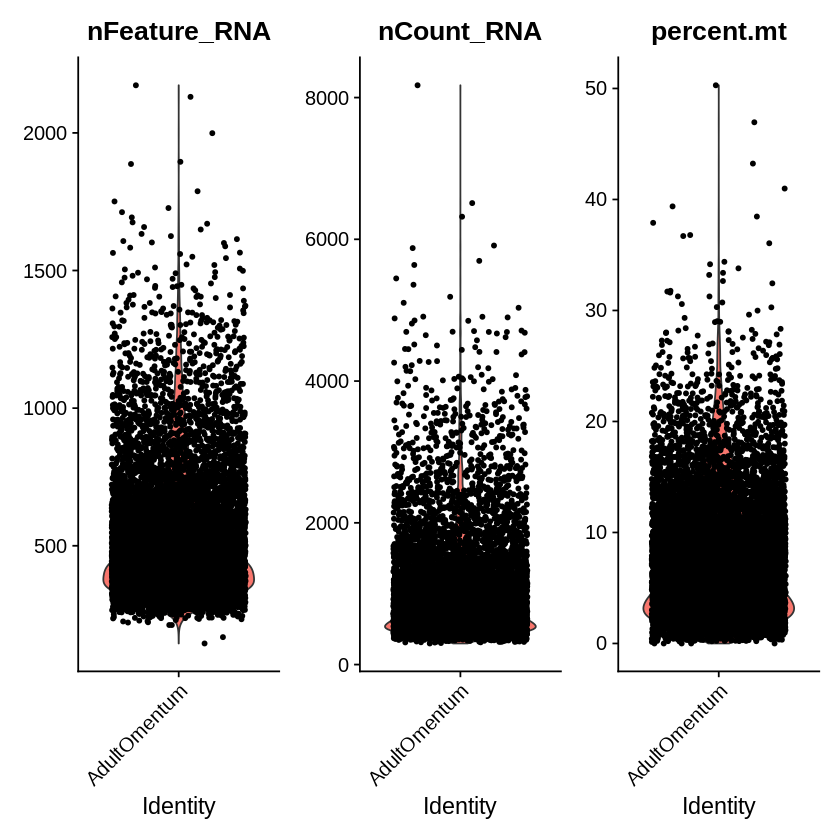

In [5]:
VlnPlot(dataobj, features = c('nFeature_RNA', 'nCount_RNA', 'percent.mt'), ncol = 3)

In [6]:
# QC
nFeature_RNA_range = c(200, 2500)
percent.mt.thre = 5
dataobj <- subset(dataobj, subset = nFeature_RNA > nFeature_RNA_range[1] & nFeature_RNA < nFeature_RNA_range[2] & percent.mt < percent.mt.thre)


In [7]:
# Normalization
# Two approaches
# 1. run standard log normalization 
dataobj <- NormalizeData(dataobj, normalization.method = "LogNormalize", scale.factor = 10000)
dataobj <- FindVariableFeatures(dataobj, selection.method = 'vst', nfeatures = 2000) # default feature number, nfeatures = 2000
dataobj <- ScaleData(dataobj, features = VariableFeatures(dataobj))
# 2. run sctransform 
# dataobj <- SCTransform(dataobj, vars.to.regress = "percent.mt", do.correct.umi = TRUE, do.scale = TRUE, do.center = TRUE)

Centering and scaling data matrix



In [8]:
# Dimensional Reduction
dataobj <- RunPCA(dataobj, features = VariableFeatures(object = dataobj))
# Determine the ‘dimensionality’ of the dataset according to elbow plot

PC_ 1 
Positive:  CXCL8, C1QA, HLA-DRA, AIF1, RNASE1, MS4A6A, CXCL3, CD74, C1QB, CCL3 
	   IL1B, SRGN, CTSB, TYROBP, CCL4, HLA-DRB1, CCL4L2, FCER1G, CD83, LGMN 
	   C1QC, CCL3L3, BCL2A1, CTSS, CD163, LAPTM5, TNFAIP3, NR4A2, CYBB, F13A1 
Negative:  LUM, DCN, MGP, RPS18, APOD, SPARC, RPL41, TNFAIP6, IFITM3, COL3A1 
	   CXCL14, C3, RPS3, RPL36, PTGDS, COL1A2, IGFBP3, COL1A1, GAS5, CLU 
	   RPS17, SFRP2, FBN1, S100A6, IGFBP6, MT2A, CTSK, TIMP3, RPL18, ASPN 
PC_ 2 
Positive:  RNASE1, LGMN, SEPP1, F13A1, C1QA, C1QB, C1QC, FOS, CD163, LILRB5 
	   A2M, FOLR2, LYVE1, MRC1, CD209, HSPA1A, CTSZ, STAB1, CREG1, CTSB 
	   SIGLEC1, MSR1, SLC40A1, ACP5, CCL13, SLCO2B1, IER3, CTSD, MS4A4A, TGFBI 
Negative:  CD52, FCN1, PLAC8, EREG, LST1, S100A8, ARHGDIB, BCL2A1, SAMSN1, AREG 
	   MNDA, FCER1G, SERPINA1, S100A9, SRGN, LYZ, CD48, GMFG, S100A12, CSTA 
	   CARD16, FPR1, CXCR4, CREM, HCST, NKG7, SH3BGRL3, B2M, CYTIP, C15orf48 
PC_ 3 
Positive:  NKG7, GZMA, CCL5, GZMB, GNLY, TRBC2, STMN1, CST7, CXCR4, CTSW 


Warning message in ElbowPlot(dataobj, ndims = 100):
“The object only has information for 50 reductions”


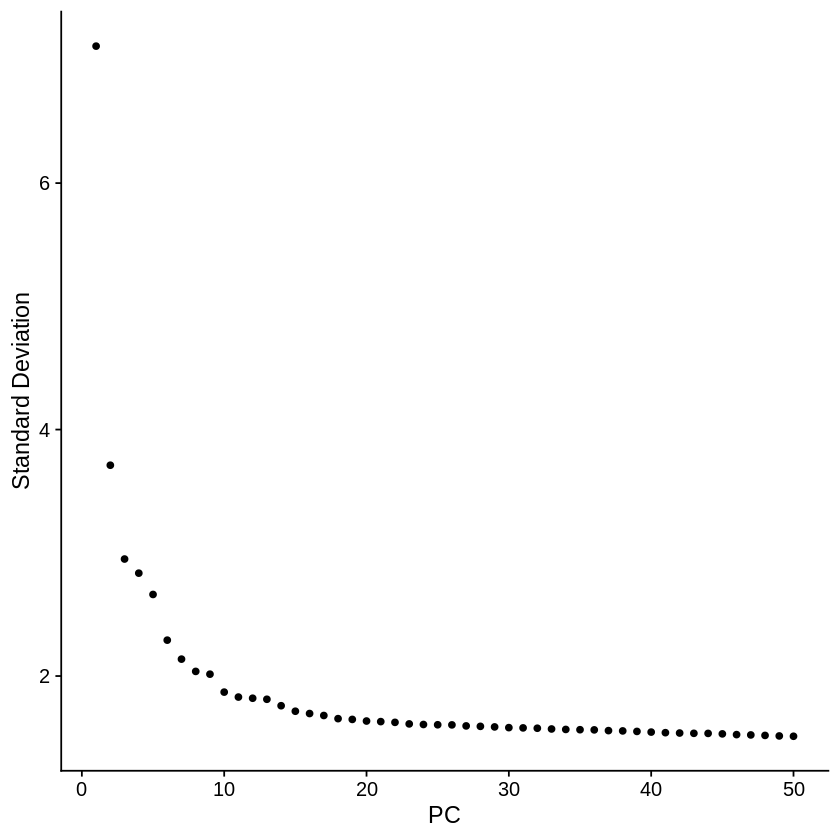

In [9]:
ElbowPlot(dataobj, ndims=100) 
# pdf(paste0(datasetName,"seurat.elbowplot.pdf"))

In [10]:
dev.off()
pcDim = 10 # set as 50 in this case 
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)
DimPlot(dataobj, reduction = "umap", label = TRUE)
# ggsave(paste0(datasetName,".seurat.umap.tiff", plot = p_umap, width = 8, height = 5)

null device 
          1

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
19:59:41 UMAP embedding parameters a = 0.9922 b = 1.112

19:59:41 Read 3685 rows and found 10 numeric columns

19:59:41 Using Annoy for neighbor search, n_neighbors = 30

19:59:41 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

19:59:41 Writing NN index file to temp file /tmp/RtmpfnbHbB/file74574765d31c

19:59:41 Searching Annoy index using 1 thread, search_k = 3000

19:59:42 Annoy recall = 100%

19:59:43 Commencing smooth kNN distance calibration using 1 thread

19:59:43 Initializing fr

In [14]:
# Cluster the cells
dataobj <- FindNeighbors(dataobj, reduction = "pca", dims = 1:pcDim, nn.eps = 0.5)
dataobj <- FindClusters(dataobj, resolution = 0.6)
# umap
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3685
Number of edges: 124655

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8274
Number of communities: 10
Elapsed time: 0 seconds


20:02:58 UMAP embedding parameters a = 0.9922 b = 1.112

20:02:58 Read 3685 rows and found 10 numeric columns

20:02:58 Using Annoy for neighbor search, n_neighbors = 30

20:02:58 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

20:02:58 Writing NN index file to temp file /tmp/RtmpfnbHbB/file74572a428034

20:02:58 Searching Annoy index using 1 thread, search_k = 3000

20:03:00 Annoy recall = 100%

20:03:00 Commencing smooth kNN distance calibration using 1 thread

20:03:00 Initializing from normalized Laplacian + noise

20:03:00 Commencing optimization for 500 epochs, with 154390 positive edges

20:03:09 Optimization finished



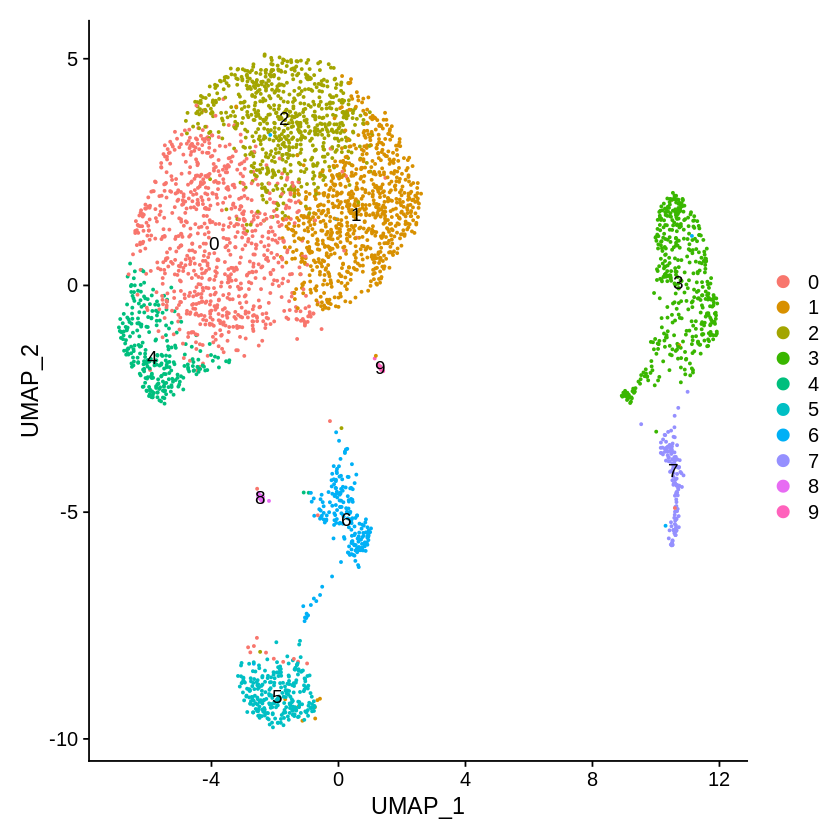

In [20]:
p_umap <- DimPlot(dataobj, reduction = "umap", label = TRUE)
p_umap

In [16]:
ggsave(paste0(datasetName,".seurat.umap.tiff"), plot = p_umap, width = 8, height = 5)

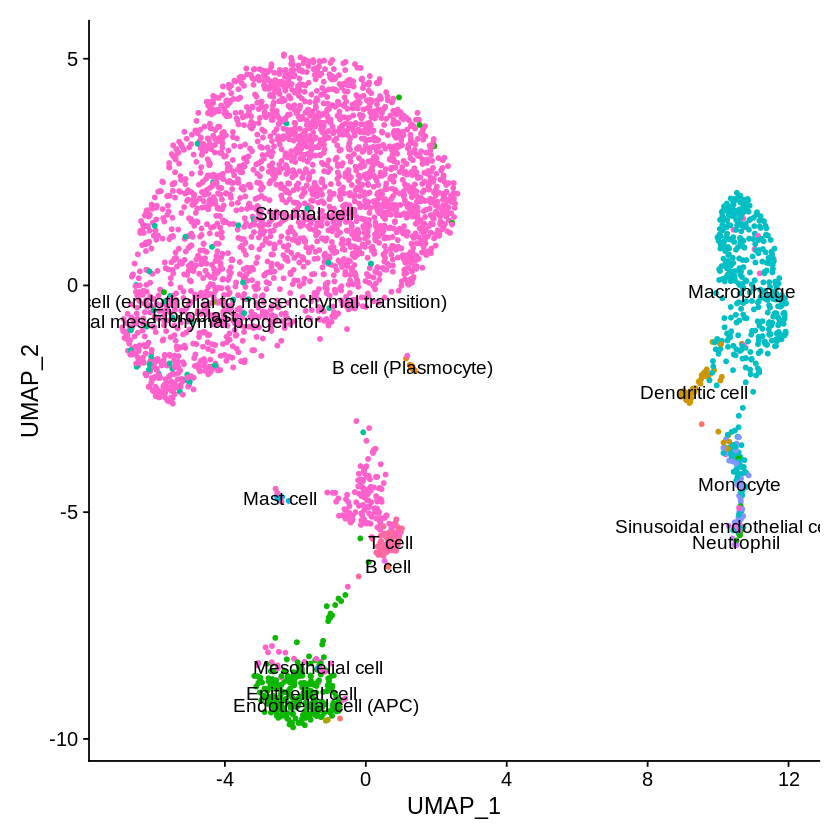

In [21]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE, group.by = "cell_cluster", pt.size=1) + NoLegend()
p_umap2

In [17]:
ggsave(paste0(datasetName,".seurat.umap_orig.tiff"), plot = p_umap2, width = 8, height = 5)

In [18]:
# Finding cluster markers 
dataobj.markers <- FindAllMarkers(dataobj, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
write.table(dataobj.markers, file = paste0(datasetName,".seurat.markers.txt"), sep = "\t", quote = F, row.names = F, col.names = T)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9



In [23]:
new.cluster.ids <- c('Eye-Connective tissue-Stromal cell-LUM', 'Eye-Connective tissue-Stromal cell-FGF7', 'Eye-Connective tissue-Stromal cell-FGF7',
                    'Eye-Connective tissue-Macrophage-CD163', 'Eye-Connective tissue-Stromal cell-LUM', 'Eye-Epithelial tissue-Mesothelial cell-KRT18',
                    'Eye-Connective tissue-T cell-NKG7', 'Eye-Connective tissue-Macrophage/Neutrophil-FCGR3A/S100A8', 'Eye-Connective tissue-Mast cell-CPA3',
                    'Eye-Connective tissue-B cell-IGKC')
names(new.cluster.ids) <- levels(dataobj)
dataobj <- RenameIdents(dataobj, new.cluster.ids)

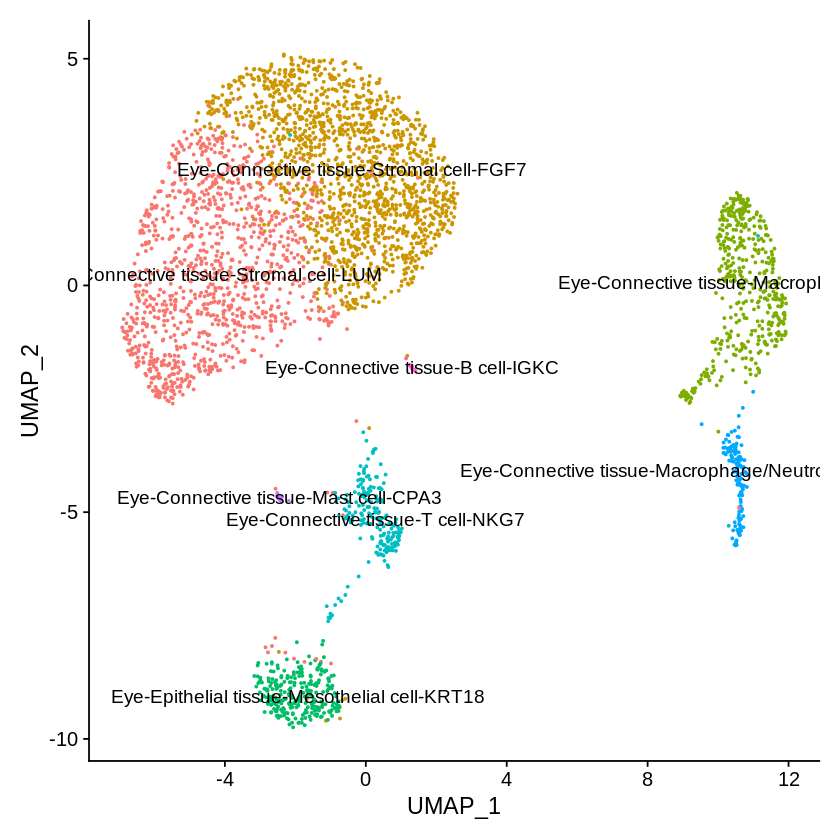

In [24]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE) + NoLegend()
p_umap2

In [25]:
ggsave(paste0(datasetName,".seurat.umap_hcad.tiff"), plot = p_umap2, width = 8, height = 5)

In [ ]:
saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))